In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from scipy.constants import c, e, m_u
from scipy.interpolate import interp1d

In [2]:
df = pd.read_csv('collated_np_all_post.csv')
nonzero_eos = df[df.logweight_total > -np.inf]

In [3]:
nonzero_eos

,eos,logweight_total,Mmax,pressurec2(baryon_density=2.8e+14),pressurec2(baryon_density=5.6e+14),pressurec2(baryon_density=1.68e+15),energy_densityc2(baryon_density=2.8e+14),energy_densityc2(baryon_density=5.6e+14),energy_densityc2(baryon_density=1.68e+15),R(M=1.4),...,logweight_LVC_GW190425_PhenomPNRThi,Lambda(M=1.6),Lambda(M=1.8),R(M=2.2),Lambda(M=1.0),Lambda(M=1.2),Lambda(M=2.2),R(M=1.2),R(M=1.0),logweight_Fonseca_J0740
6,1295491.0,-108.122200,2.603362,1.347181e+13,1.157996e+14,5.100930e+14,2.781826e+14,6.044199e+14,2.381410e+15,15.331616,...,1.271458,940.540860,489.125759,15.754375,9529.205472,3918.311595,136.240424,15.139406,14.922972,2.992386
16,801190.0,-136.954400,2.854403,2.890948e+13,1.373165e+14,1.820736e+15,2.893194e+14,6.546181e+14,2.982779e+15,17.036945,...,0.432802,1897.669815,1020.412566,17.739443,18484.235424,7847.515546,325.322795,16.799126,16.547510,2.896820
18,1045196.0,-7.759387,1.884972,8.489347e+12,5.316641e+13,5.931912e+14,2.777501e+14,5.774545e+14,2.098917e+15,13.443280,...,2.699762,252.638230,57.377955,6.498800,5005.262234,1798.461725,0.000000,13.610505,13.708024,-3.872367
23,2096819.0,-114.869400,3.450041,1.877969e+13,2.769144e+14,1.316527e+15,2.912876e+14,6.841185e+14,3.297290e+15,15.694826,...,0.909539,1292.804026,671.490172,16.567518,10723.035117,4728.758946,219.223221,15.438042,15.187293,2.701048
26,1459215.0,6.756822,2.334307,7.630696e+12,6.130517e+13,8.417335e+14,2.773685e+14,5.750875e+14,2.306016e+15,13.485055,...,2.672137,316.174724,148.323837,13.090567,4402.403684,1645.902022,29.508494,13.498957,13.540713,3.106090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309526,1715903.0,5.070087,2.015742,3.721870e+12,4.201063e+13,6.533895e+14,2.760359e+14,5.654943e+14,2.102774e+15,12.236965,...,2.854757,167.357477,64.208153,6.498800,2735.659723,1024.094641,0.000000,12.240059,12.225059,1.590082
309527,1852746.0,-5.325922,2.065641,1.408507e+13,4.716668e+13,4.344421e+14,2.783922e+14,5.812388e+14,2.152024e+15,14.406849,...,2.413807,319.536886,125.511761,6.498800,11577.001351,3319.370847,0.000000,15.122614,15.600424,2.368008
309529,525490.0,4.636692,1.993610,6.913206e+12,5.200981e+13,7.396218e+14,2.832244e+14,5.841795e+14,2.177749e+15,12.704702,...,2.558594,194.395952,62.764244,6.498800,3320.725798,1240.656025,0.000000,12.720058,12.705058,1.038965
309533,1940558.0,7.238117,2.421531,5.137387e+12,4.872923e+13,1.200798e+15,2.765713e+14,5.659790e+14,2.360391e+15,12.407550,...,2.454158,210.038765,94.753901,12.176629,2634.642611,1057.925564,18.141746,12.300436,12.161933,3.067794


In [4]:
# Download the EoSs with non-zero likelihood

# eos_dir = 'lg:/home/philippe.landry/nseos/eos/gp/mrgagn'
# target_dir = 'eos-draws'

# for eos in nonzero_eos.eos:
#     eos = int(eos)
#     os.system(f'scp {eos_dir}/DRAWmod1000-{int(eos/1000):06}/eos-draw-{eos:06}.csv {target_dir}/')

In [5]:
def to_GeV_per_cubic_femtometre(x):

    # Convert to J/cm^3
    x = x*c**2/1000

    # Convert to GeV/fm^3
    return x*(1/(1e9*e))*((1e-15)**3/(0.01**3))

def to_nucleons_per_cubic_femtometre(x):

    # Convert to kg/fm^3
    x = (x/1000)*((1e-15)**3/(0.01**3))

    # Divide by the atomic mass constant to get nucleons/fm^3
    return x/m_u

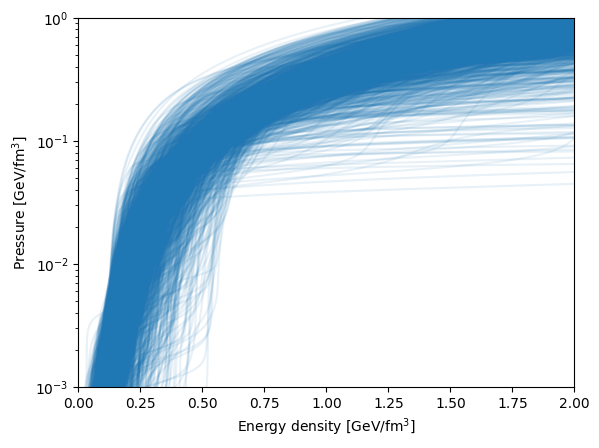

In [6]:
fig, ax = plt.subplots()
ax.set_yscale('log')

for eos in nonzero_eos.eos[:2000]:

    eos = int(eos)

    df = pd.read_csv(f'eos-draws/eos-draw-{eos:06}.csv')

    pressure = df.pressurec2
    energy_density = df.energy_densityc2

    ax.plot(
        to_GeV_per_cubic_femtometre(energy_density), 
        to_GeV_per_cubic_femtometre(pressure), 
        alpha=0.1, 
        c='C0'
        )

ax.set_ylim(1e-3, 1)
ax.set_xlim(0., 2)

ax.set_xlabel('Energy density [GeV/fm$^3$]')
_ = ax.set_ylabel('Pressure [GeV/fm$^3$]')

In [7]:
def weighted_quantile(values, quantiles, weights):

    sorter = np.argsort(values)
    values = values[sorter]
    weights = weights[sorter]

    weighted_quantiles = np.cumsum(weights)
    weighted_quantiles /= np.sum(weights)
    
    return np.interp(quantiles, weighted_quantiles, values)

In [8]:
energy_density_grid = np.linspace(1e-10, 5, 1000)
pressure_interp = []
number_density_interp = []

for eos in nonzero_eos.eos[:2000]:

    eos = int(eos)

    df = pd.read_csv(f'eos-draws/eos-draw-{eos:06}.csv')

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2).values
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2).values
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density).values

    pressure_interp.append(interp1d(energy_density, pressure)(energy_density_grid))
    number_density_interp.append(interp1d(energy_density, number_density)(energy_density_grid))

In [9]:
pressure_interp = np.array(pressure_interp)
number_density_interp = np.array(number_density_interp)

In [10]:
unweighted_quantiles = np.quantile(pressure_interp, [0.05, 0.5, 0.95], axis=0)

In [11]:
weights = np.exp(nonzero_eos.logweight_total[:2000].values)

In [12]:
weighted_quantiles = []

for i in range(len(energy_density_grid)):
    weighted_quantiles.append(weighted_quantile(pressure_interp[:,i], [0.05, 0.5, 0.95], weights=weights))

In [13]:
weighted_quantiles = np.array(weighted_quantiles).T

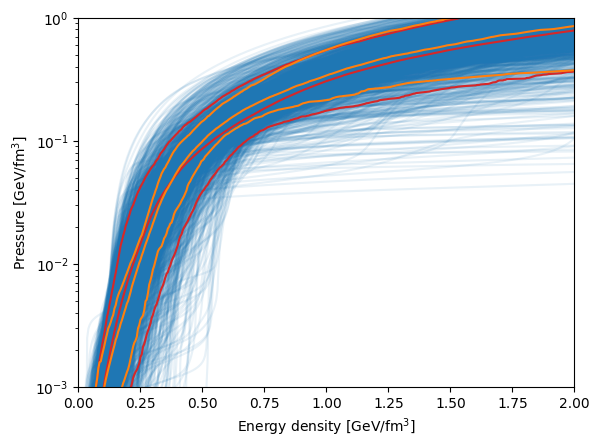

In [14]:
fig, ax = plt.subplots()
ax.set_yscale('log')

for p in pressure_interp:

    ax.plot(
        energy_density_grid, 
        p, 
        alpha=0.1, 
        c='C0'
        )
    
ax.plot(energy_density_grid, unweighted_quantiles[0], c='C3')
ax.plot(energy_density_grid, unweighted_quantiles[1], c='C3')
ax.plot(energy_density_grid, unweighted_quantiles[2], c='C3')

ax.plot(energy_density_grid, weighted_quantiles[0], c='C1')
ax.plot(energy_density_grid, weighted_quantiles[1], c='C1')
ax.plot(energy_density_grid, weighted_quantiles[2], c='C1')

ax.set_ylim(1e-3, 1)
ax.set_xlim(0., 2)

ax.set_xlabel('Energy density [GeV/fm$^3$]')
_ = ax.set_ylabel('Pressure [GeV/fm$^3$]')

In [15]:
from pQCD import pQCD

def qcd_likelihood(e, p, n, N=1000):

    weight = np.zeros(N)

    for i in range(N):
        
        X = np.random.uniform(np.log(1/2), np.log(2)) # Log-linear distribution
        pQCDX = pQCD(np.exp(X)) # Redefine class with new X
        
        # For each X assign 0 or 1 for given point
        weight[i] = int(pQCDX.constraints(e0=e,p0=p,n0=n))

    return weight.mean()

In [16]:
matching_density = 10*0.15

qcd_weights = []

for p, n in zip(pressure_interp, number_density_interp):

    # Find the pressure and energy density at the chosen matching density
    index = np.argmin(np.abs(n - matching_density))
    e = energy_density_grid[index]
    p = p[index]

    qcd_weights.append(qcd_likelihood(e, p, matching_density))


In [17]:
qcd_weights = np.array(qcd_weights)

In [18]:
combined_weights = weights*qcd_weights

In [19]:
weighted_quantiles_combined = []

for i in range(len(energy_density_grid)):
    weighted_quantiles_combined.append(weighted_quantile(pressure_interp[:,i], [0.05, 0.5, 0.95], weights=combined_weights))

weighted_quantiles_combined = np.array(weighted_quantiles_combined).T

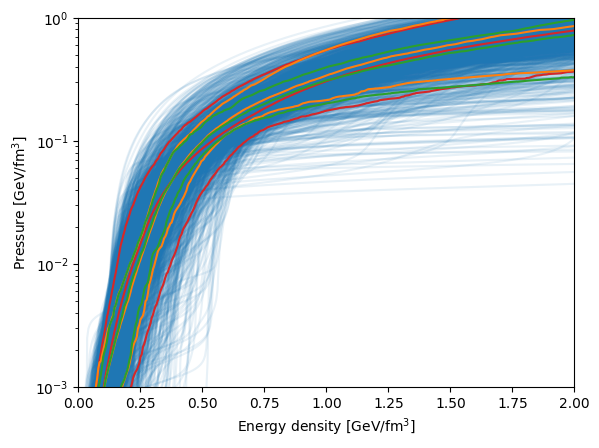

In [20]:
fig, ax = plt.subplots()
ax.set_yscale('log')

for p in pressure_interp:

    ax.plot(
        energy_density_grid, 
        p, 
        alpha=0.1, 
        c='C0'
        )
    
ax.plot(energy_density_grid, unweighted_quantiles[0], c='C3')
ax.plot(energy_density_grid, unweighted_quantiles[1], c='C3')
ax.plot(energy_density_grid, unweighted_quantiles[2], c='C3')

ax.plot(energy_density_grid, weighted_quantiles[0], c='C1')
ax.plot(energy_density_grid, weighted_quantiles[1], c='C1')
ax.plot(energy_density_grid, weighted_quantiles[2], c='C1')

ax.plot(energy_density_grid, weighted_quantiles_combined[0], c='C2')
ax.plot(energy_density_grid, weighted_quantiles_combined[1], c='C2')
ax.plot(energy_density_grid, weighted_quantiles_combined[2], c='C2')

ax.set_ylim(1e-3, 1)
ax.set_xlim(0., 2)

ax.set_xlabel('Energy density [GeV/fm$^3$]')
_ = ax.set_ylabel('Pressure [GeV/fm$^3$]')

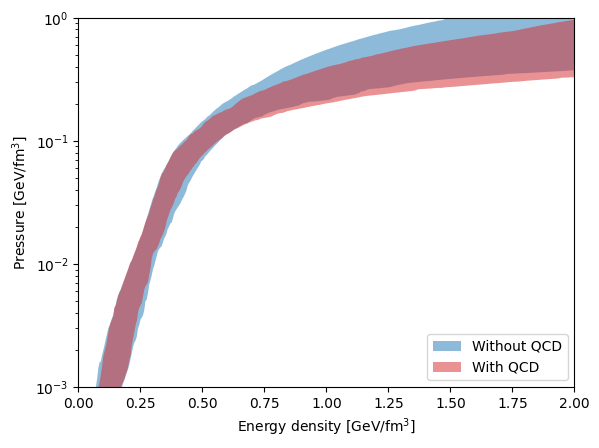

In [21]:
fig, ax = plt.subplots()
ax.set_yscale('log')

# for p in pressure_interp:

#     ax.plot(
#         energy_density_grid, 
#         p, 
#         alpha=0.05, 
#         c='C0'
#         )
    
ax.fill_between(
    energy_density_grid, 
    weighted_quantiles[0], 
    weighted_quantiles[2], 
    alpha=0.5, 
    color='C0', 
    edgecolor=None,
    label='Without QCD'
    )

ax.fill_between(
    energy_density_grid, 
    weighted_quantiles_combined[0], 
    weighted_quantiles_combined[2], 
    alpha=0.5, 
    color='C3', 
    edgecolor=None,
    label='With QCD'
    )

ax.legend(loc='lower right')

ax.set_ylim(1e-3, 1)
ax.set_xlim(0., 2)

ax.set_xlabel('Energy density [GeV/fm$^3$]')
_ = ax.set_ylabel('Pressure [GeV/fm$^3$]')